In [ ]:
import dynamax
import jax
import jax.numpy as jnp
from jax import jit, lax, vmap, value_and_grad
from dynamax.hidden_markov_model import PoissonHMM, HMM
import jax.random as jr
from dynamax.parameters import ParameterProperties
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from itertools import count
import matplotlib.pyplot as plt

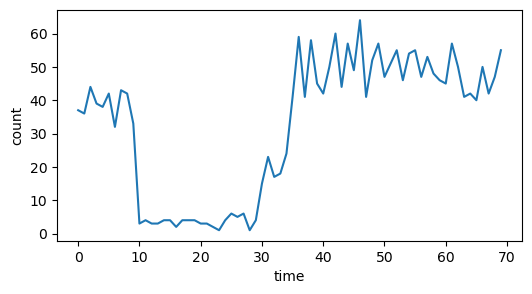

In [8]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]
keys = map(jr.PRNGKey, count())

emissions = jnp.concatenate(
    [
        jr.poisson(key, rate, (num_steps,))
        for (key, rate, num_steps) in zip(keys, true_rates, true_durations)
    ]
).astype(jnp.float32)

# PoissonHMM requires are least 1D emissions
emissions = emissions[:, None]

plt.figure(figsize=(6, 3))
plt.plot(emissions)
plt.xlabel("time")
plt.ylabel("count");

In [15]:
class NonconjugatePoissonHMM(PoissonHMM):
    """A Poisson HMM with a nonconjugate prior.    
    """
    def __init__(self, num_states, emission_dim, 
                 initial_probs_concentration=1.1,
                 transition_matrix_concentration=1.1,
                 emission_prior_loc=0.0,
                 emission_prior_scale=1.0):
        HMM.__init__(self,
            num_states,
            initial_component=initial_probs_concentration,
            transition_component=transition_matrix_concentration)
        self.emission_dim = emission_dim
        self.emission_prior_loc = emission_prior_loc
        self.emission_prior_scale = emission_prior_scale
        
    def initialize(self, key, method="prior", initial_probs=None, transition_matrix=None, rates=None):
        key1, key2 = jr.split(key)
        params, props = HMM.initialize(self, key=key1, 
                                               method=method, 
                                               initial_probs=initial_probs, 
                                               transition_matrix=transition_matrix)
        
        if rates is None:
            prior = tfd.LogNormal(self.emission_prior_loc, self.emission_prior_scale)
            rates = prior.sample(seed=key2, sample_shape=(self.num_states, self.emission_dim))
            
        params['emissions'] = dict(rates=rates)
        props['emissions'] = dict(rates=ParameterProperties(constrainer=tfb.Softplus()))
        return params, props
        
    def log_prior(self, params):
        return tfd.LogNormal(self.emission_prior_loc, self.emission_prior_scale).log_prob(
            params["emissions"]["rates"]
        ).sum()
        
    # Default to the standard E and M steps rather than the conjugate updates
    # for the PoissonHMM with a gamma prior.
    def e_step(self, params, batch_emissions):
        return StandardHMM.e_step(self, params, batch_emissions)
    
    def m_step(self, params, param_props, batch_emissions, batch_posteriors, **batch_covariates):
        return StandardHMM.m_step(self, params, param_props, batch_emissions, batch_posteriors, **batch_covariates)

In [12]:
def build_latent_state(num_states, max_num_states, daily_change_prob):
    # Give probability 0 to states outside of the current model.
    def prob(s):
        return jnp.where(s < num_states + 1, 1 / num_states, 0.0)

    states = jnp.arange(1, max_num_states + 1)
    initial_state_probs = vmap(prob)(states)

    # Build a transition matrix that transitions only within the current
    # `num_states` states.
    def transition_prob(i, s):
        return jnp.where(
            (s <= num_states) & (i <= num_states) & (1 < num_states),
            jnp.where(s == i, 1 - daily_change_prob, daily_change_prob / (num_states - 1)),
            jnp.where(s == i, 1, 0),
        )

    transition_probs = vmap(transition_prob, in_axes=(None, 0))(states, states)

    return initial_state_probs, transition_probs

In [13]:
num_states = 4
daily_change_prob = 0.05

initial_state_probs, transition_probs = build_latent_state(num_states, num_states, daily_change_prob)
print("Initial state probs:\n{}".format(initial_state_probs))
print("Transition matrix:\n{}".format(transition_probs))

Initial state probs:
[0.25 0.25 0.25 0.25]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


In [ ]:
hmm = NonconjugatePoissonHMM(num_states, 
                             emission_dim=1, 
                             emission_prior_loc=jnp.log(emissions.mean()), 
                             emission_prior_scale=1.0)